# Analysis of homogenized temperature data from the Netherlands

This notebook contains some Python code to analyze [homogenized monthly temperature data since 1901](http://projects.knmi.nl/klimatologie/onderzoeksgegevens/homogeen_260/tg_hom_mnd260.txt) from KNMI's *De Bilt* weather station.

## Import prerequisites:

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

from scipy.optimize import curve_fit

from bokeh.io       import show, output_notebook
from bokeh.layouts  import layout
from bokeh.models   import Range1d
from bokeh.palettes import d3
from bokeh.plotting import figure

output_notebook()

tools = "pan,wheel_zoom,box_zoom,reset,save".split(',')

pd.set_option('display.max_columns', 40)

mycolors  = [d3['Category10'][10][i] for i in range(10)]
mycolors2 = [d3['Category20'][20][i] for i in range(20)]

%load_ext watermark
%watermark -a "Author: gmalim" 
print("")
%watermark -u -n
print("")
%watermark -v -p numpy,pandas,scipy,matplotlib,bokeh
print("")
%watermark -m

/Users/uci/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Loading BokehJS ...

Author: gmalim

last updated: Fri Aug 10 2018

CPython 3.6.5
IPython 6.5.0

numpy 1.15.0
pandas 0.23.4
scipy 1.1.0
matplotlib 2.2.2
bokeh 0.13.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit


## Data processing

Load data:

In [2]:
df = pd.read_csv('tg_hom_mnd260.txt', names=['DATE', 'TGH'], skiprows=28, sep=' ', skipinitialspace=True)
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
df = df.set_index('DATE')

print(df.shape)

(1411, 1)


Select time period:

In [3]:
# Date selection:

start_year = 1901
end_year   = 2017

start_date = '{}-01-01'.format(start_year)
end_date   = '{}-12-31'.format(end_year)

df = df.loc[start_date:end_date]

print(df.shape)

(1404, 1)


In [4]:
display(df.describe().round(1))

#npoints = df.shape[0]

,TGH
count,1404.0
mean,9.4
std,5.6
min,-6.8
25%,4.7
50%,9.3
75%,14.5
max,22.2


In [5]:
print("--> Total number of months in data set with homogenized monthly temperatures > 20 C =", len(df[(df['TGH']>20)]))

--> Total number of months in data set with homogenized monthly temperatures > 20 C = 5


Plot data:

In [6]:
fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "KNMI homogenized monthly temperature data {}-{}, De Bilt station".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Homogenized monthly temperature (C)"
fig1.y_range=Range1d(-10,30)

fig1.circle(x=df.index, y=df.TGH, size=5, color=mycolors[2], muted_color=mycolors[2], alpha=0.5, muted_alpha=0.03)

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

# Temperature distributions per month

Create month column in dataframe:

In [7]:
df = df.reset_index()

df['month'] = df['DATE'].dt.strftime('%m')
df['month'] = df['month'].astype('int64')

months = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 
          7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}

#for key in months.keys():    
#    df_tmp = df[(df['month'] == key)]
#    print(df_tmp.TGH.describe().round(1))

Create Gaussian function:

In [8]:
def mygaussian(x, ampl, mu, sigma):
    #return ampl/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))
    return ampl*np.exp(-(x-mu)**2/(2*sigma**2))

pg_min = ( 1, -10,  0.5)
pg_max = (50,  30, 10.0)
pg_bounds = (pg_min, pg_max)

Fit monthly temperature distributions with Gaussian functions:

Fitted Gaussian (January): 10.2*exp(-(x-2.8)^2/(2*2.2^2))
Fitted Gaussian (February): 10.4*exp(-(x-3.3)^2/(2*2.2^2))
Fitted Gaussian (March): 12.0*exp(-(x-5.2)^2/(2*2.0^2))
Fitted Gaussian (April): 17.3*exp(-(x-8.3)^2/(2*1.3^2))
Fitted Gaussian (May): 17.1*exp(-(x-12.7)^2/(2*1.4^2))
Fitted Gaussian (June): 18.1*exp(-(x-15.1)^2/(2*1.3^2))
Fitted Gaussian (July): 16.3*exp(-(x-16.8)^2/(2*1.4^2))
Fitted Gaussian (August): 18.0*exp(-(x-16.4)^2/(2*1.3^2))
Fitted Gaussian (September): 21.8*exp(-(x-13.9)^2/(2*1.0^2))
Fitted Gaussian (October): 16.5*exp(-(x-10.3)^2/(2*1.4^2))
Fitted Gaussian (November): 14.4*exp(-(x-6.0)^2/(2*1.6^2))
Fitted Gaussian (December): 12.7*exp(-(x-3.8)^2/(2*1.7^2))


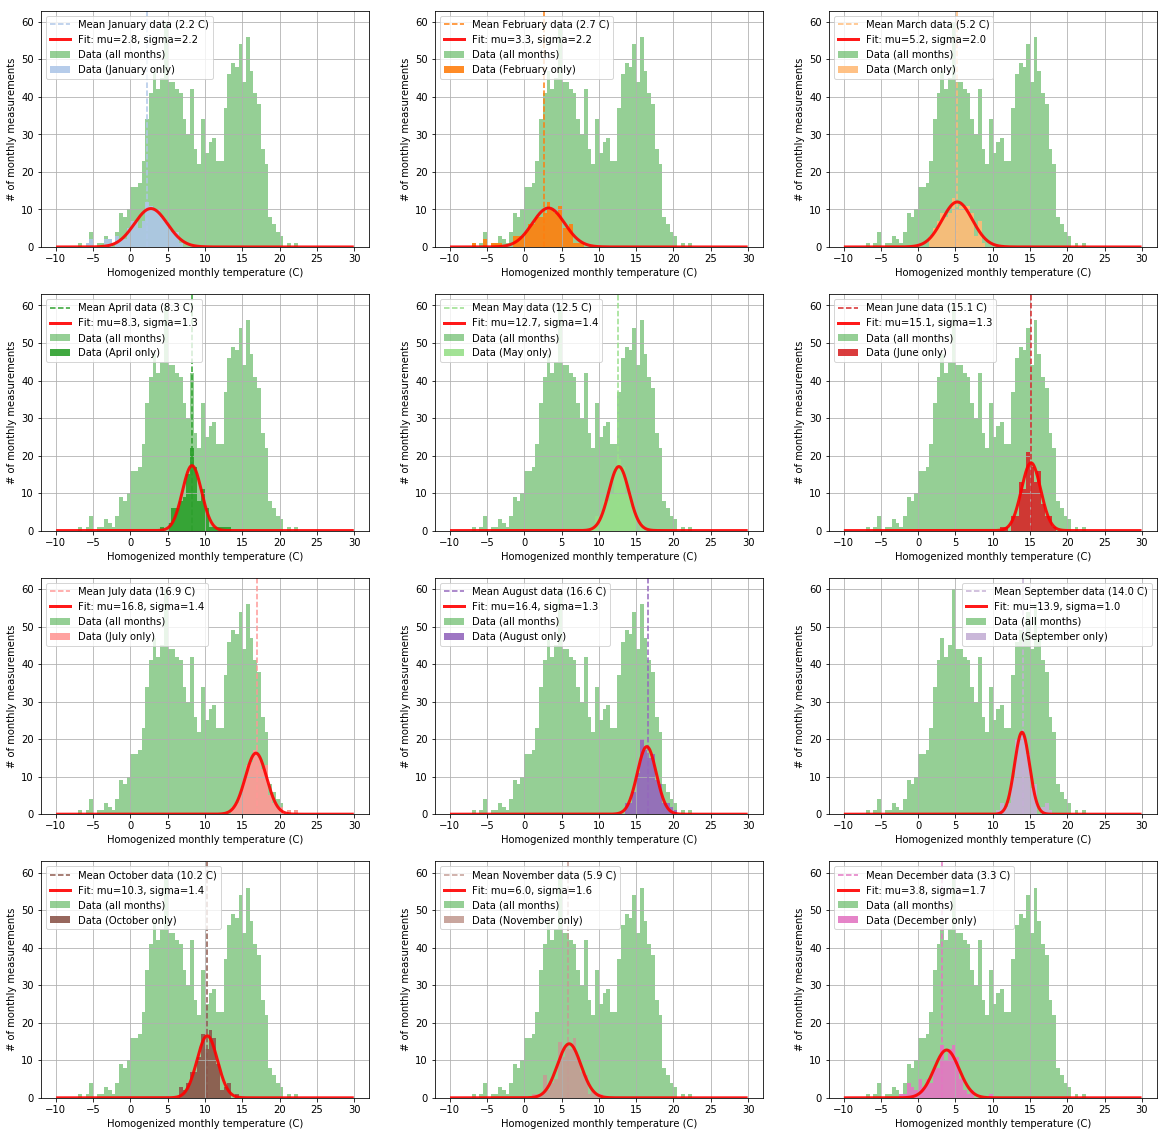

In [9]:
plt.figure(figsize=(20, 20))

mu_data    = []
mu_fit     = []
sigma_data = []
sigma_fit  = []

for monthindex, month in months.items():

    plt.subplot(4, 3, monthindex)
    
    plt.hist(x=df.TGH, range=(-10,30), bins=80, alpha=0.5, color=mycolors[2], label='Data (all months)')
    
    df_tmp = df[(df['month'] == monthindex)]
    
    mu_data   .append(df_tmp.TGH.mean())
    sigma_data.append(df_tmp.TGH.std())
        
    bincontents_tmp, binedges_tmp, _ = plt.hist(x=df_tmp.TGH, range=(-10,30), bins=80,
                                                color=mycolors2[monthindex], alpha=0.9, 
                                                label='Data ({} only)'.format(month))
    
    bincentralvalues_tmp = [(binedges_tmp[i]+binedges_tmp[i+1])/2 for i in range(len(binedges_tmp)-1)]
    
    mean_tmp = df_tmp.TGH.mean()
    
    plt.axvline(x=mean_tmp, linestyle='--', color=mycolors2[monthindex], 
                label='Mean {} data ({:.1f} C)'.format(month, mean_tmp))
        
    x_data_tmp = bincentralvalues_tmp
    y_data_tmp = bincontents_tmp
    
    pg_start_tmp = [15, mean_tmp, 2]

    pg_opt_tmp, pg_cov_tmp = curve_fit(mygaussian, x_data_tmp, y_data_tmp, p0=pg_start_tmp, bounds=pg_bounds)

    mu_fit   .append(pg_opt_tmp[1])
    sigma_fit.append(pg_opt_tmp[2])
    
    label_g_tmp = "Fitted Gaussian ({}): {:.1f}*exp(-(x-{:.1f})^2/(2*{:.1f}^2))".format(month, *pg_opt_tmp)

    print(label_g_tmp)
    
    x_fit_tmp = np.linspace(min(x_data_tmp), max(x_data_tmp), num=len(x_data_tmp)*10)
    y_fit_tmp = mygaussian(x_fit_tmp, *pg_opt_tmp)

    plt.plot(x_fit_tmp, y_fit_tmp, lw=3, color='red', alpha=0.9,
             label="Fit: mu={:.1f}, sigma={:.1f}".format(pg_opt_tmp[1], pg_opt_tmp[2]))
    
    plt.legend(loc='best')
    plt.ylabel('# of monthly measurements')
    plt.xlabel('Homogenized monthly temperature (C)')
    plt.grid(True)

Create sine function:

In [10]:
def myfunc1(x, ampl, hoffset, voffset):
    return  ampl*np.sin(2*np.pi*(x - hoffset)/12) + voffset

p1_start = [1, 0, 0]
p1_min = (     0,  0, -np.inf)
p1_max = (np.inf, 12,  np.inf)
p1_bounds = (p1_min, p1_max)

Fit mean monthly temperature distribution with sine function:

In [11]:
x_data = range(1,13)
#y_data = mu_data
y_data = mu_fit

#y_data_sigma = sigma_data/np.sqrt(df.shape[0]/12) # sigma_mean = sigma/sqrt(N) 
y_data_sigma = sigma_fit /np.sqrt(df.shape[0]/12) # sigma_mean = sigma/sqrt(N)

p1_opt, p1_cov = curve_fit(myfunc1, x_data, y_data, p0=p1_start, bounds=p1_bounds,
                           sigma=y_data_sigma, absolute_sigma=True)

print("Fitted sine function: f(t) = ampl*sin(2π(t - hoffset)/12) + voffset")
print("")
print("--> Fitted parameters [ampl, hoffset, voffset]:")
print(p1_opt.round(3))
print("--> Covariance matrix:")
print(p1_cov)
p1_err = np.sqrt(np.diag(p1_cov))
print("--> Fitted parameter standard deviations:")
print(p1_err.round(3))
y_fit = myfunc1(x_data, *p1_opt)
residual = y_data - y_fit
chisq = np.sum((residual/y_data_sigma)**2)
ndata = len(x_data)
npfit = len(p1_opt)
print('--> chisq/ndf = {:.2f}/({:.2g}-{:.2g}) = {:.2f}'.format(chisq, ndata, npfit, chisq/(ndata - npfit)))

Fitted sine function: f(t) = ampl*sin(2π(t - hoffset)/12) + voffset

--> Fitted parameters [ampl, hoffset, voffset]:
[7.305 4.224 9.512]
--> Covariance matrix:
[[ 3.72419698e-03 -1.76067949e-05 -8.61720926e-04]
 [-1.76067949e-05  1.83946803e-04 -4.07440460e-05]
 [-8.61720926e-04 -4.07440460e-05  1.68104151e-03]]
--> Fitted parameter standard deviations:
[0.061 0.014 0.041]
--> chisq/ndf = 53.04/(12-3) = 5.89


Plot mean monthly temperatures & fitted sine function, and the monthly temperature range (mean_data +/- 1 sigma_data):

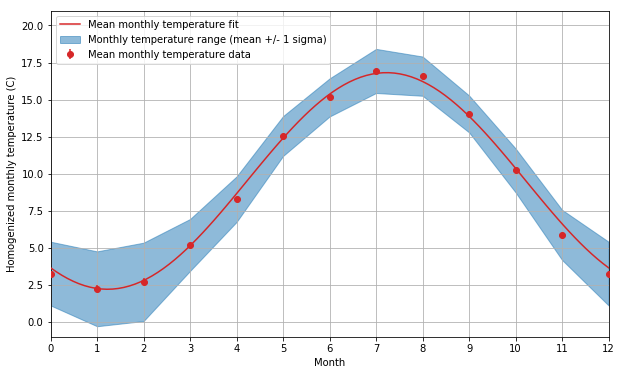

In [12]:
plt.figure(figsize=(10,6))

monthindices = range(0,13)

mus_tmp = [mu_data[-1]]
for i in mu_data:
    mus_tmp.append(i)

sigmas_tmp = [sigma_data[-1]]
for i in sigma_data:
    sigmas_tmp.append(i)

min_temp = np.subtract(mus_tmp, sigmas_tmp)
max_temp = np.add     (mus_tmp, sigmas_tmp)

mu_stdev = np.array(sigmas_tmp)
mu_stdev = mu_stdev/np.sqrt(df.shape[0]/12)

plt.fill_between(monthindices, min_temp, max_temp, color=mycolors[0], alpha=0.5, 
                 label='Monthly temperature range (mean +/- 1 sigma)')
plt.errorbar(monthindices, mus_tmp, yerr=mu_stdev, color=mycolors[3], fmt='o', zorder=10, 
             label='Mean monthly temperature data')

x_fit = np.linspace(0, 12, num=100)
y_fit = myfunc1(x_fit, *p1_opt)

plt.plot(x_fit, y_fit, color=mycolors[3], label='Mean monthly temperature fit', zorder=10)

plt.legend(loc='upper left')
plt.xticks(monthindices)
plt.xlabel('Month')
plt.ylabel('Homogenized monthly temperature (C)')
plt.xlim(0, 12)
plt.ylim(-1, 21)
plt.grid(True)

Plot and fit temperature distributions:

# Temperature-time distributions per month

Create quantities needed to fit temperature-time distributions:

In [13]:
#TGH_sigma = np.mean(sigma_data)

x_data = df.index
y_data = df.TGH
y_data_sigma = []

for i in range(0, len(x_data)):
    month_i = df.month[i]
    sigma_i = sigma_fit[month_i-1]
    y_data_sigma.append(sigma_i)

Create functions to fit temperature-time distributions:

In [14]:
def myfunc2(x, slope, voffset): # 1st order polynomial function
    return slope*x + voffset

p2_start = [0, 0]
p2_min = (-np.inf, -np.inf)
p2_max = ( np.inf,  np.inf)
p2_bounds = (p2_min, p2_max)

In [15]:
def myfunc3(x, ampl, hoffset, slope, voffset): # sine + 1st order polynomial function
    return ampl*np.sin(2*np.pi*(x - hoffset)/12) + slope*x + voffset

p3_start = [1, 0, 0, 0]
p3_min = (     0,  0, -np.inf, -np.inf)
p3_max = (np.inf, 12,  np.inf,  np.inf)
p3_bounds = (p3_min, p3_max)

Fit temperature-time distributions:

In [16]:
p1_opt, p1_cov = curve_fit(myfunc1, x_data, y_data, p0=p1_start, bounds=p1_bounds,
                           sigma=y_data_sigma, absolute_sigma=True)

print("Fitted sine function: f(t) = ampl*sin(2π(t - hoffset)/12) + voffset")
print("")
print("--> Fitted parameters [ampl, hoffset, voffset]:")
print(p1_opt)
print("--> Covariance matrix:")
print(p1_cov)
p1_err = np.sqrt(np.diag(p1_cov))
print("--> Fitted parameter standard deviations:")
print(p1_err)
y_fit = myfunc1(x_data, *p1_opt)
residual = y_data - y_fit
chisq = np.sum((residual/y_data_sigma)**2)
ndata = len(x_data)
npfit = len(p1_opt)
print('--> chisq/ndf = {:f}/({:g}-{:g}) = {:f}'.format(chisq, ndata, npfit, chisq/(ndata - npfit)))

label1 = "Fitted sine: {:.2f}*sin(2π(t - {:.2f})/12) + {:.2f}".format(*p1_opt)

Fitted sine function: f(t) = ampl*sin(2π(t - hoffset)/12) + voffset

--> Fitted parameters [ampl, hoffset, voffset]:
[7.5861767  3.22437537 9.38504266]
--> Covariance matrix:
[[ 3.72416763e-03 -1.70105909e-05 -8.61754796e-04]
 [-1.70105909e-05  1.70561879e-04 -3.91862959e-05]
 [-8.61754796e-04 -3.91862959e-05  1.68104151e-03]]
--> Fitted parameter standard deviations:
[0.06102596 0.01305993 0.04100051]
--> chisq/ndf = 1736.613913/(1404-3) = 1.239553


In [17]:
p2_opt, p2_cov = curve_fit(myfunc2, x_data, y_data, p0=p2_start, bounds=p2_bounds,
                           sigma=y_data_sigma, absolute_sigma=True)

print("Fitted 1st order polynomial function: f(t) = slope*t + voffset")
print("")
print("--> Fitted parameters [slope, voffset]:")
print(p2_opt)
print("--> Covariance matrix:")
print(p2_cov)
p2_err = np.sqrt(np.diag(p2_cov))
print("--> Fitted parameter standard deviations:")
print(p2_err)
y_fit = myfunc2(x_data, *p2_opt)
residual = y_data - y_fit
chisq = np.sum((residual/y_data_sigma)**2)
ndata = len(x_data)
npfit = len(p2_opt)
print('--> chisq/ndf = {:f}/({:g}-{:g}) = {:f}'.format(chisq, ndata, npfit, chisq/(ndata - npfit)))

label2 = "Fitted pol1: {:.4f}*t + {:.2f}".format(*p2_opt)

Fitted 1st order polynomial function: f(t) = slope*t + voffset

--> Fitted parameters [slope, voffset]:
[1.20077561e-03 1.03061039e+01]
--> Covariance matrix:
[[ 8.95341340e-09 -6.28652176e-06]
 [-6.28652176e-06  5.88472687e-03]]
--> Fitted parameter standard deviations:
[9.46224783e-05 7.67119735e-02]
--> chisq/ndf = 17035.754345/(1404-2) = 12.151037


In [18]:
p3_opt, p3_cov = curve_fit(myfunc3, x_data, y_data, p0=p3_start, bounds=p3_bounds,
                           sigma=y_data_sigma, absolute_sigma=True)

print("Fitted sine + 1st order polynomial function: f(t) = ampl*sin(2π(t - hoffset)/12) + slope*t + voffset")
print("")
print("--> Fitted parameters [ampl, hoffset, slope, voffset]:")
print(p3_opt)
print("--> Covariance matrix:")
print(p3_cov)
p3_err = np.sqrt(np.diag(p3_cov))
print("--> Fitted parameter standard deviations:")
print(p3_err)
y_fit = myfunc3(x_data, *p3_opt)
residual = y_data - y_fit
chisq = np.sum((residual/y_data_sigma)**2)
ndata = len(x_data)
npfit = len(p3_opt)
print('--> chisq/ndf = {:f}/({:g}-{:g}) = {:f}'.format(chisq, ndata, npfit, chisq/(ndata - npfit)))

label3 = "Fitted sine + pol1: {:.2f}*sin(2π(t - {:.2f})/12) + {:.4f}*t + {:.2f}".format(*p3_opt)

Fitted sine + 1st order polynomial function: f(t) = ampl*sin(2π(t - hoffset)/12) + slope*t + voffset

--> Fitted parameters [ampl, hoffset, slope, voffset]:
[7.58535302e+00 3.22342535e+00 1.18668109e-03 8.55226214e+00]
--> Covariance matrix:
[[ 3.72423890e-03 -1.68780836e-05 -6.20775294e-09 -8.57320830e-04]
 [-1.68780836e-05  1.70600507e-04 -7.16886107e-09 -3.42675600e-05]
 [-6.20775294e-09 -7.16886107e-09  8.95372756e-09 -6.28348251e-06]
 [-8.57320830e-04 -3.42675600e-05 -6.28348251e-06  6.09061865e-03]]
--> Fitted parameter standard deviations:
[6.10265426e-02 1.30614129e-02 9.46241384e-05 7.80424157e-02]
--> chisq/ndf = 1579.337292/(1404-4) = 1.128098


Create fitted functions:

In [19]:
x_fit = np.linspace(x_data.min(), x_data.max(), num=len(x_data)*10)

y_fit1 = myfunc1(x_fit, *p1_opt)
y_fit2 = myfunc2(x_fit, *p2_opt)
y_fit3 = myfunc3(x_fit, *p3_opt)

Plot temperature-time distributions and fitted functions:

In [20]:
from bokeh.models import ColumnDataSource, Whisker

fig1 = figure(plot_width=900, plot_height=450, tools=tools, toolbar_location='above')
fig1.title.text = "Homogenized monthly temperatures {}-{}, KNMI weather station De Bilt".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Time (months since Jan 1901)"
fig1.yaxis.axis_label = "Homogenized monthly temperature (C)"
fig1.y_range=Range1d(-10,25)

source_error = ColumnDataSource(data=dict(base=x_data, lower=(y_data-y_data_sigma), upper=(y_data+y_data_sigma)))

fig1.add_layout(Whisker(source=source_error, base="base", upper="upper", lower="lower"))

fig1.circle(x=df.index, y=df.TGH, #legend='Data',
            size=5, color=mycolors[2], muted_color=mycolors[2], alpha=0.7, muted_alpha=0.03)

fig1.line(x=x_fit, y=y_fit1, legend=label1,
          line_width=3, color=mycolors[0], muted_color=mycolors[0], alpha=0.7, muted_alpha=0.03)

fig1.line(x=x_fit, y=y_fit2, legend=label2,
          line_width=3, color=mycolors[1], muted_color=mycolors[1], alpha=0.7, muted_alpha=0.03)

fig1.line(x=x_fit, y=y_fit3, legend=label3,
          line_width=3, color=mycolors[3], muted_color=mycolors[3], alpha=0.7, muted_alpha=0.03)

fig1.legend.location = 'bottom_right'
fig1.legend.click_policy = 'mute'

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

In [21]:
df_jan = df[(df['month'] == 1)] # | (df['month'] == 2)]
df_jul = df[(df['month'] == 7)] # | (df['month'] == 8)]

df_jan['fullindex'] = df_jan.index
df_jul['fullindex'] = df_jul.index

df_jan = df_jan.reset_index()
df_jul = df_jul.reset_index()

x_data_jan = df_jan.fullindex
x_data_jul = df_jul.fullindex

y_data_jan = df_jan.TGH
y_data_jul = df_jul.TGH

y_data_jan_sigma = []
y_data_jul_sigma = []

for i in range(len(x_data_jan)):
    month_i = df_jan.month[i]
    sigma_i = sigma_fit[month_i-1]
    y_data_jan_sigma.append(sigma_i)
    
for i in range(len(x_data_jul)):
    month_i = df_jul.month[i]
    sigma_i = sigma_fit[month_i-1]
    y_data_jul_sigma.append(sigma_i)

/Users/uci/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/uci/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Fit winter and summer temperature-time distributions:

In [22]:
p_jan, p_jan_cov = curve_fit(myfunc2, x_data_jan, y_data_jan, p0=p2_start, bounds=p2_bounds,
                             sigma=y_data_jan_sigma, absolute_sigma=True)

print("Fitted 1st order polynomial function: f(t) = slope*t + voffset")
print("")
print("--> Fitted parameters [slope, voffset]:")
print(p_jan)
print("--> Covariance matrix:")
print(p_jan_cov)
p_jan_err = np.sqrt(np.diag(p_jan_cov))
print("--> Fitted parameter standard deviations:")
print(p_jan_err)
y_fit = myfunc2(x_data_jan, *p_jan)
residual = y_data_jan - y_fit
chisq = np.sum((residual/y_data_jan_sigma)**2)
ndata = len(x_data_jan)
npfit = len(p_jan)
print('--> chisq/ndf = {:f}/({:g}-{:g}) = {:f}'.format(chisq, ndata, npfit, chisq/(ndata - npfit)))

label_jan = "Fitted pol1: {:f}*t + {:.2f}".format(*p_jan)

Fitted 1st order polynomial function: f(t) = slope*t + voffset

--> Fitted parameters [slope, voffset]:
[1.19718560e-03 1.40373319e+00]
--> Covariance matrix:
[[ 2.53758951e-07 -1.76616229e-04]
 [-1.76616229e-04  1.64606324e-01]]
--> Fitted parameter standard deviations:
[0.00050374 0.40571705]
--> chisq/ndf = 146.030118/(117-2) = 1.269827


In [23]:
p_jul, p_jul_cov = curve_fit(myfunc2, x_data_jul, y_data_jul, p0=p2_start, bounds=p2_bounds, 
                             sigma=y_data_jul_sigma, absolute_sigma=True)

print("Fitted 1st order polynomial function: f(t) = slope*t + voffset")
print("")
print("--> Fitted parameters [slope, voffset]:")
print(p_jul)
print("--> Covariance matrix:")
print(p_jul_cov)
p_jul_err = np.sqrt(np.diag(p_jul_cov))
print("--> Fitted parameter standard deviations:")
print(p_jul_err)
y_fit = myfunc2(x_data_jul, *p_jul)
residual = y_data_jul - y_fit
chisq = np.sum((residual/y_data_jul_sigma)**2)
ndata = len(x_data_jul)
npfit = len(p_jul)
print('--> chisq/ndf = {:f}/({:g}-{:g}) = {:f}'.format(chisq, ndata, npfit, chisq/(ndata - npfit)))

label_jul = "Fitted pol1: {:f}*t + {:.2f}".format(*p_jul)

Fitted 1st order polynomial function: f(t) = slope*t + voffset

--> Fitted parameters [slope, voffset]:
[1.45505948e-03 1.59112235e+01]
--> Covariance matrix:
[[ 1.04924149e-07 -7.36567523e-05]
 [-7.36567523e-05  6.89414613e-02]]
--> Fitted parameter standard deviations:
[0.00032392 0.26256706]
--> chisq/ndf = 107.058455/(117-2) = 0.930943


Create fitted winter and summer temperature-time distributions:

In [24]:
y_fit_jan = myfunc2(x_fit, *p_jan)
y_fit_jul = myfunc2(x_fit, *p_jul)

Plot winter and summer temperature-time distributions and fitted functions:

In [25]:
fig1 = figure(plot_width=900, plot_height=450, tools=tools, toolbar_location='above')
fig1.title.text = "Homogenized monthly temperatures {}-{}, KNMI weather station De Bilt".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Time (months since January 1901)"
fig1.yaxis.axis_label = "Homogenized monthly temperature (C)"
fig1.x_range=Range1d(-50,2000)
fig1.y_range=Range1d(-10,25)

fig1.circle(x=df.index, y=df.TGH, #legend='All data',
            size=5, color=mycolors[2], muted_color=mycolors[2], alpha=0.7, muted_alpha=0.03)

fig1.circle(x=df_jul.fullindex, y=df_jul.TGH, legend='July data',
            size=10, color=mycolors[3], muted_color=mycolors[3], alpha=0.7, muted_alpha=0.03)

fig1.circle(x=df_jan.fullindex, y=df_jan.TGH, legend='January data',
            size=10, color=mycolors[0], muted_color=mycolors[0], alpha=0.7, muted_alpha=0.03)

#fig1.line(x=x_fit, y=y_fit2, legend=label2,
#          line_width=3, color=mycolors[2], muted_color=mycolors[2], alpha=1, muted_alpha=0.03)

fig1.line(x=x_fit, y=y_fit_jul, legend=label_jul,
          line_width=3, color=mycolors[3], muted_color=mycolors[3], alpha=1, muted_alpha=0.03)

fig1.line(x=x_fit, y=y_fit_jan, legend=label_jan,
          line_width=3, color=mycolors[0], muted_color=mycolors[0], alpha=1, muted_alpha=0.03)

fig1.legend.location = 'bottom_right'
fig1.legend.click_policy = 'mute'

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);